In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import re

In [3]:
patient_df = pd.read_csv("patient_info.csv", error_bad_lines = False, engine = "python")
video_df = pd.read_csv(r"video_watched.csv", error_bad_lines=False, engine = "python")

# Clean Patient Data & Feature Engineering

This section of code creates patient_vector which is a matrix that represents all the patients based on different features. First, we pull from the data given in the .csv file on the patients. Then for each patient we get the number of times they've watched each video (0 if they haven't watched). Then these two matrices are joined on patient ID. We do one-hot encoding for categorical features.

In [4]:
# pull wanted columns for csv
patient_data =  patient_df[['patient_id', 'user_id', 'provider_id', 'organization_id', 'datetime_created', 'age', 'sex', 'has_bh_specialist', 'organization_name', 'product_tier', 'total_activities_done', 'unique_days_with_activity']]
# reformate datetime_created
current = date.fromisoformat("2020-11-29")
patient_data['datetime_created'] = patient_data['datetime_created'].apply(lambda x : int((current - date.fromisoformat(x[0:10])).days))
patient_data = patient_data.rename(columns = {'datetime_created' : 'account_age_days'})

# pull out patient watch data (i.e. video watch events per patient)
patient_watch_data = video_df[['datetime_created', 'id','patient_id', 'video_id', 'subsection_watched_from']]
# reformate datetime_created
patient_watch_data['datetime_created'] = patient_watch_data['datetime_created'].apply(lambda x : int((current - date.fromisoformat(x[0:10])).days))
patient_watch_data = patient_watch_data.rename(columns = {"datetime_created" : "record_age"})

<ipython-input-4-8f47ae287782>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_data['datetime_created'] = patient_data['datetime_created'].apply(lambda x : int((current - date.fromisoformat(x[0:10])).days))
<ipython-input-4-8f47ae287782>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_watch_data['datetime_created'] = patient_watch_data['datetime_created'].apply(lambda x : int((current - date.fromisoformat(x[0:10])).days))


In [5]:
# get unique patients and videos
patients = patient_df['patient_id'].drop_duplicates()
videos = video_df['video_id'].drop_duplicates()

# create a dateframe to store the watch count of videos
patient_watch_count = pd.DataFrame(index = patients, columns = videos).fillna(0)
video_cnt = video_df[['patient_id', 'video_id']]
cnt = video_cnt.value_counts()

# populate dataframe to store the watch count of videos / patient
for index in cnt.index:
    value = cnt[index[0], index[1]]
    patient_watch_count.at[index[0], index[1]] = value


# add sum column as an additional feature (sum of videos watched)
patient_watch_count['sum'] = patient_watch_count.sum(axis = 1)

In [6]:
### GET MOST WATCHED VIDEOS ###
#most_watch = patient_watch_count.describe().transpose()['mean']
#most_watch.sort_values(ascending = False)

In [6]:
# go through each entry of video count / patient and divide by sum to normalize
#for index in cnt.index:
    #value = patient_watch_count.at[index[0], index[1]]
    #sum = patient_watch_count.at[index[0], "sum"]
    #patient_watch_count.at[index[0], index[1]] = value / sum
# end

In [7]:
# Join patient_data (features from csv) with watch history - then use one-hot encoding 
patient_vectors_ = pd.DataFrame.merge(patient_watch_count, patient_data, how = "right", left_on = "patient_id", right_on = "patient_id")
patient_vectors_ = patient_vectors_.drop_duplicates()
patient_vectors = pd.get_dummies(patient_vectors_)

In [8]:
patient_vectors

,patient_id,624,620,787,771,2587,707,2595,3021,3023,...,organization_name_Trauma & Anxiety Resolution,organization_name_Unified Counseling & Mediation,organization_name_Valley Medical & Wellness,organization_name_iRestore FRP,organization_name_private clinic,organization_name_private practice,product_tier_Empower,product_tier_EngageBH,product_tier_Integrate Health,product_tier_Other
0,26207,1,2,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,26208,0,0,0,0,1,0,1,2,1,...,0,0,0,0,0,0,0,0,1,0
2,26209,0,0,0,0,1,0,2,0,0,...,0,0,0,0,0,0,0,0,1,0
3,26211,0,0,0,0,1,0,0,0,2,...,0,0,0,0,0,0,0,0,1,0
4,26212,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9614,84426,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9615,84432,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9616,84438,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9617,84456,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [9]:
patient_vectors.to_csv("patient_features.csv")

In [ ]:
#for col in data_dummies.columns:
    #if(isinstance(col, str)):
        #print(col)

In [ ]:
#temp_list = []

#for row in data_dummies.index:
    #for col in data_dummies.columns:
        #if(data_dummies.at[row,col] not in temp_list):
            #temp_list.append(data_dummies.at[row,col])
#end

#for el in temp_list:
    #print(el)

# Run KMeans on Processed Patient Data

This section of the code runs KMeans machine learning algorithm to categorize like patients. The elbow method is used to determine what the optimal k might look like.

In [8]:
import sklearn
from sklearn.cluster import KMeans

In [18]:
patient_vectors_encoded = patient_vectors[~patient_vectors.isin([np.nan, np.inf, -np.inf]).any(1)]
patient_vectors_encoded = patient_vectors_encoded.set_index("patient_id")

9571

In [21]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(patient_vectors_encoded)
    distortions.append(kmeanModel.inertia_)
    #len(kmeansModel.labels_)



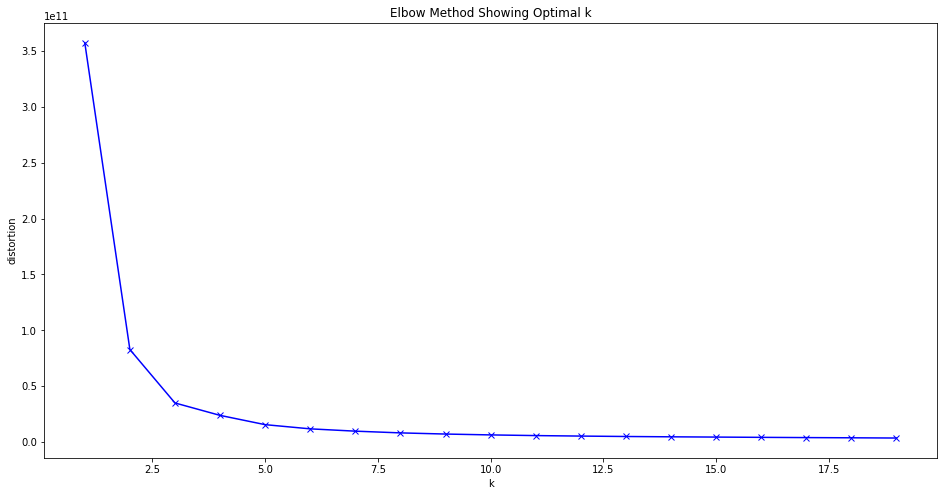

In [22]:
plt.figure(figsize = (16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('distortion')
plt.title('Elbow Method Showing Optimal k')
plt.show()